In [1]:
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

In [2]:
app_data = pd.read_csv("appreviews.csv")

In [3]:
app_data

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1
...,...,...
19991,this app is fricken stupid.it froze on the kin...,0
19992,Please add me!!!!! I need neighbors! Ginger101...,1
19993,love it! this game. is awesome. wish it had m...,1
19994,I love love love this app on my side of fashio...,1


(array([ 4766.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15230.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

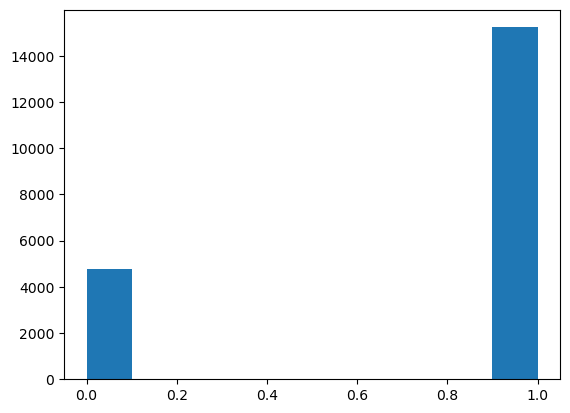

In [4]:
plt.hist(app_data["label"])

In [5]:
corpus = []
ps = PorterStemmer()

for i in range(len(app_data)):

    app_sentiment = re.sub('[^a-zA-Z]', ' ',app_data["Text"][i])
    app_sentiment = app_sentiment.lower()
    app_sentiment = app_sentiment.split()
    clean_sentiment = [ps.stem(word) for word in app_sentiment if not word in set(stopwords.words('english'))]
    clean_sentiment = ' '.join(clean_sentiment)
    corpus.append(clean_sentiment)

In [6]:
vectorizer = TfidfVectorizer(min_df = 4, max_df = 0.5)

In [7]:
X = vectorizer.fit_transform(corpus).toarray()
y = app_data["label"].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 55, stratify = y)

In [9]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [10]:
X_train.shape, y_train.shape

(torch.Size([13997, 3919]), torch.Size([13997]))

In [11]:
X_test.shape, y_test.shape

(torch.Size([5999, 3919]), torch.Size([5999]))

In [12]:
torch.manual_seed(40)

In [13]:
class Model(nn.Module):
    def __init__(self, input_features = 3919, h1 = 1282, h2 = 522):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(input_features, h1)
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.fc2 = torch.nn.Linear(h1, h2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.fc3 = torch.nn.Linear(h2, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        
        return x

In [14]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.BCELoss()

In [15]:
epochs = 50
losses = []

for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Epoch: {i} and loss: {loss.item()}")

Epoch: 0 and loss: 0.707023024559021
Epoch: 10 and loss: 0.2166428416967392
Epoch: 20 and loss: 0.10834284871816635
Epoch: 30 and loss: 0.0162670761346817
Epoch: 40 and loss: 0.007620689924806356


In [16]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    print(y_pred)

binary_predictions = (y_pred >= 0.5).float()

# Compare binary predictions to true labels
correct = (binary_predictions == y_test.view(-1, 1)).sum().item()
# Calculate total number of samples
total = y_test.size(0)

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2%}")

tensor([[1.0000],
        [1.0000],
        [1.0000],
        ...,
        [0.0086],
        [1.0000],
        [1.0000]])
Test Accuracy: 85.73%
